# Background

This assignment is the final deliverable for CSCA5632 (Unsupervised Algorithms in Machine Learning). The goal of this assignment is to find a dataset and apply unsupervised learning methods to achieve an outcome.

### Dataset
The dataset I have chosen comes from the University of California Irvine's Machine Learning Repository. The goal is to identify the type of landmine based on sensor data. This is an important task to protect the life and property of those looking to cross over areas that may contain landmines.

UCI Machine Learning Repository. (n.d.). Archive.ics.uci.edu.

    https://archive.ics.uci.edu/dataset/763/land+mines-1

### Import packages and data

In [1]:
import pandas as pd
import ucimlrepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from itertools import permutations
%matplotlib inline

In [2]:
data = ucimlrepo.fetch_ucirepo(id=763)

X = data.data.features
y = data.data.targets

In [3]:
# citation
print(data.metadata["additional_info"]["citation"])

Yilmaz, C., Kahraman, H. T., & Söyler, S. (2018). Passive mine detection and classification method based on hybrid model. IEEE Access, 6, 47870-47888.


### Exploratory Analysis

In [4]:
data.variables

,name,role,type,demographic,description,units,missing_values
0,V,Feature,Continuous,None,voltage: output voltage value of FLC sensor du...,V,no
1,H,Feature,Continuous,None,high: the height of the sensor from the ground,cm,no
2,S,Feature,Continuous,None,soil type: 6 different soil types depending on...,None,no
3,M,Target,Integer,None,mine type: mine types commonly encountered on ...,None,no


In [5]:
y.head()

,M
0,1
1,1
2,1
3,1
4,1


<Figure size 640x480 with 0 Axes>

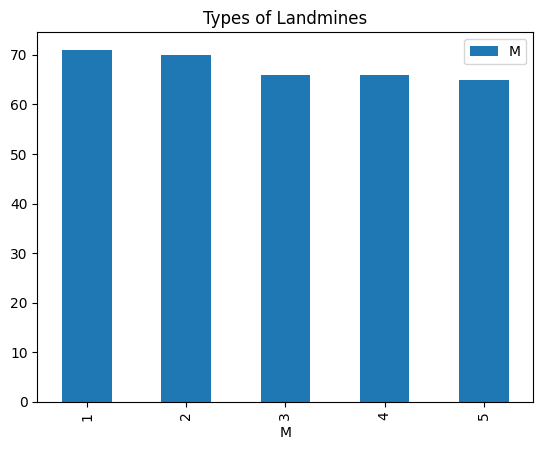

In [6]:
plt.figure()
y.groupby("M").agg({"M": "count"}).plot(kind="bar", title="Types of Landmines")
plt.show()

The target variable is called "M" and the categories of landmines appear to be fairly uniformly distributed. This means that I don't need to worry about an imbalanced dataset.

In [7]:
X.head()

,V,H,S
0,0.338157,0.000000,0.0
1,0.320241,0.181818,0.0
2,0.287009,0.272727,0.0
3,0.256284,0.454545,0.0
4,0.262840,0.545455,0.0


In [8]:
X.describe()

,V,H,S
count,338.000000,338.000000,338.000000
mean,0.430634,0.508876,0.503550
std,0.195819,0.306043,0.344244
min,0.197734,0.000000,0.000000
25%,0.309737,0.272727,0.200000
50%,0.359516,0.545455,0.600000
75%,0.482628,0.727273,0.800000
max,0.999999,1.000000,1.000000


<Figure size 1000x1000 with 0 Axes>

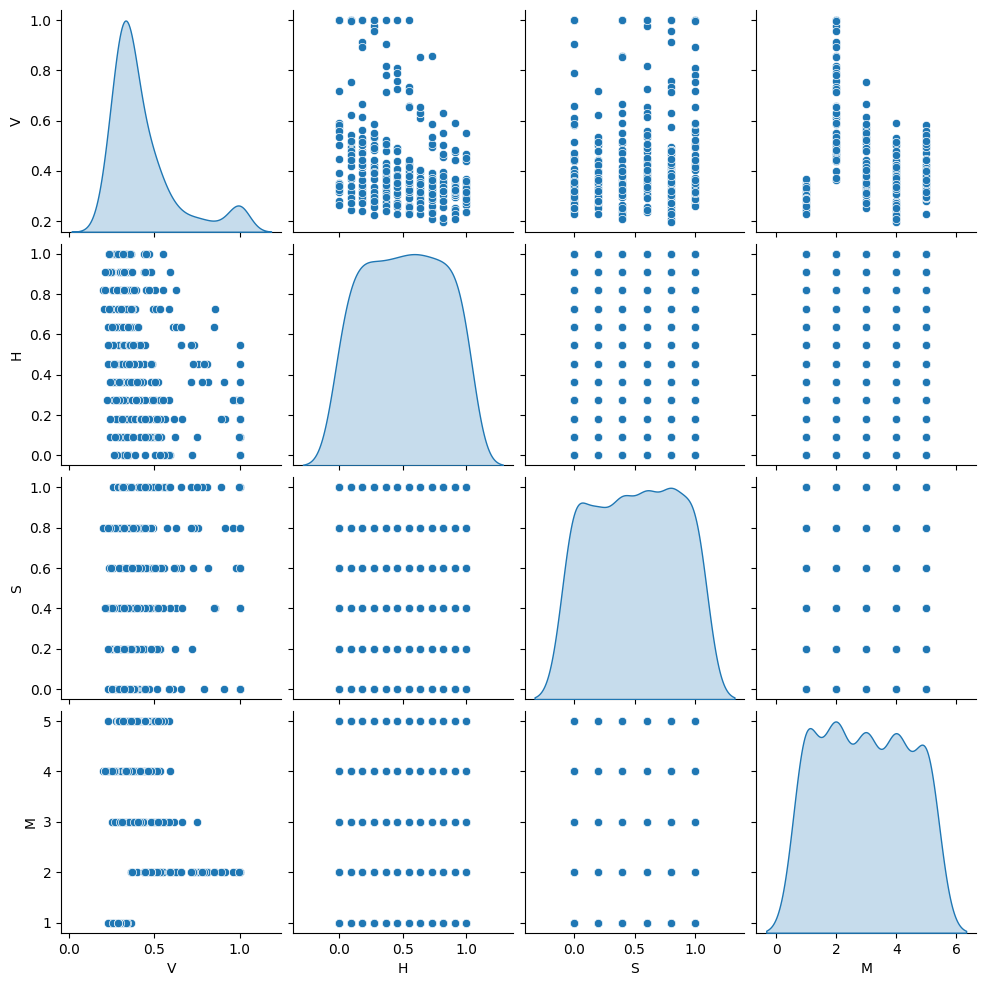

In [9]:
plt.figure(figsize=(10,10))
sns.pairplot(pd.concat([X, y], axis=1), diag_kind="kde")
plt.show()

A few of the pairplot diagrams stand out:
- M x V: m=2 seems to be correlated with higher V and m=1 seems to be correlated with lower v
- The distributions of H and S seem pretty uniform
- There don't appear to be many interesting takeaways from this diagram, maybe a 3d scatter plot would be more helpful

It is also evident from the pairplot that the data has been normalized/standardized to be between 0-1 so no additional preprocessing is required here for unsupervised methods. There also don't seem to be any extreme outliers.

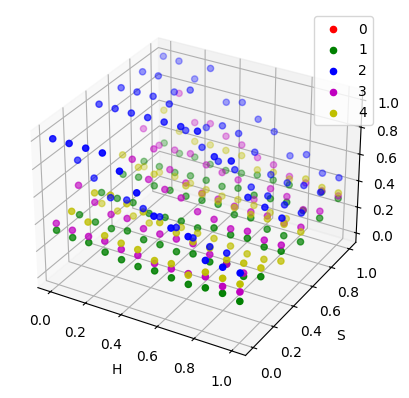

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
for i, c in zip(range(5), ("r", "g", "b", "m", "y")):
    ax.scatter(X[y["M"]==i]["H"], X[y["M"]==i]["S"], X[y["M"]==i]["V"], c=c, label=i)
ax.set_xlabel("H")
ax.set_ylabel("S")
ax.set_zlabel("V")
ax.legend()
plt.show()

From the graph it looks like there are some layers which separate out the different types of landmines. For example, V seems to separate out target=2 from the others.

### Build a baseline supervised learning model

In [11]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
# build a baseline dummy classifier
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)

print(f"Dummy classifier accuracy on train set: {dummy.score(X_train, y_train):.4f}")
print(f"Dummy classifier accuracy on test set: {dummy.score(X_test, y_test):.4f}")

Dummy classifier accuracy on train set: 0.1741
Dummy classifier accuracy on test set: 0.1765


In [13]:
# build a baseline SVC -- this is a good model to test out given that we don't have many data points and the data looks like it may be separable by a plane
svc_dict = {
    "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
    "kernel": ["linear", "rbf", "sigmoid"],
}
svc = GridSearchCV(SVC(), svc_dict)
svc.fit(X_train, y_train["M"])

svc_best = svc.best_estimator_

print(f"SVC classifier accuracy on train set: {svc_best.score(X_train, y_train):.4f}")
print(f"SVC classifier accuracy on test set: {svc_best.score(X_test, y_test):.4f}")

SVC classifier accuracy on train set: 0.7815
SVC classifier accuracy on test set: 0.5441


The model suffers from a high degree of overfitting to the training set despite a lot of regularization.

In [14]:
# build a baseline RF
rf_dict = {
    "n_estimators": [2, 5, 10],
    "max_depth": [1, 2, 3],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [2]
}
rf = GridSearchCV(RandomForestClassifier(), rf_dict)
rf.fit(X_train, y_train["M"])

rf_best = rf.best_estimator_

print(f"Random Forest classifier accuracy on train set: {rf_best.score(X_train, y_train):.4f}")
print(f"Random Forest classifier accuracy on test set: {rf_best.score(X_test, y_test):.4f}")

Random Forest classifier accuracy on train set: 0.5444
Random Forest classifier accuracy on test set: 0.3676


The model suffers from a high degree of overfitting to the training set despite attempts at simplifying the model (ex. reducing max depth, increasing the minimum samples per split and leaf).

Currently the best supervised approach yields a test accuracy of ~0.6.

### Unsupervised approach

In [15]:
# using KMeans clustering as we already know the number of clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_train)

def get_accuracy_score(model, X, y):
    # original labels are already 1-5 so I will scale them down to 0-4
    yTransformed = y - 1

    pred = model.predict(X)
    best_accuracy = -1
    for labels in permutations(range(5)):
        predIter = [labels[i] for i in pred]
        acc = accuracy_score(yTransformed, predIter)
        best_accuracy = max(acc, best_accuracy)
    
    return best_accuracy

print(f"KMeans accuracy on train set: {get_accuracy_score(kmeans, X_train, y_train)}")
print(f"KMeans accuracy on test set: {get_accuracy_score(kmeans, X_test, y_test)}")

KMeans accuracy on train set: 0.27037037037037037
KMeans accuracy on test set: 0.3088235294117647


Going back to the initial EDA, this model likely didn't perform as well because there didn't seem to be many, if any, correlations between any of the features with the target. This means that the different types of landmines have similar features.

In [16]:
# testing out gaussian mixture model to model soft clusters since boundaries are a bit fuzzy
gmm = GaussianMixture(n_components=3)
gmm.fit(X_train)

print(f"GMM accuracy on train set: {get_accuracy_score(gmm, X_train, y_train)}")
print(f"GMM accuracy on test set: {get_accuracy_score(gmm, X_test, y_test)}")

GMM accuracy on train set: 0.3962962962962963
GMM accuracy on test set: 0.4264705882352941


In this case GMM outperforms Kmeans. This is likely because it generates soft clusters rather than hard clusters. This is important since the EDA showed us that there weren't many features that could help set apart the classes.